#千葉県の自転車盗難について
千葉県警察のオープンデータを用いてグラフやマップにして表し、被害状況や対応策を考えていきます。

まずは、年齢別に被害状況をグラフにして考察します。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import folium
from folium.plugins import HeatMap

from tqdm import tqdm
from geopy.geocoders import Nominatim
import time


In [2]:
df = pd.read_csv("jitennsha.csv", encoding="utf-8")


In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.rcParams["font.family"] = "MS Gothic"   # WindowsならこれでOK


In [4]:
# 年齢カテゴリのリスト（あなたのデータに含まれていたもの）
age_order = [
    '10歳未満','10歳代','20歳代','30歳代','40歳代',
    '50歳代','60-64歳','65-69歳','70歳以上',
    '法人・団体、被害者なし'
]

df['年齢カテゴリ'] = pd.Categorical(df['被害者の年齢'], categories=age_order, ordered=True)


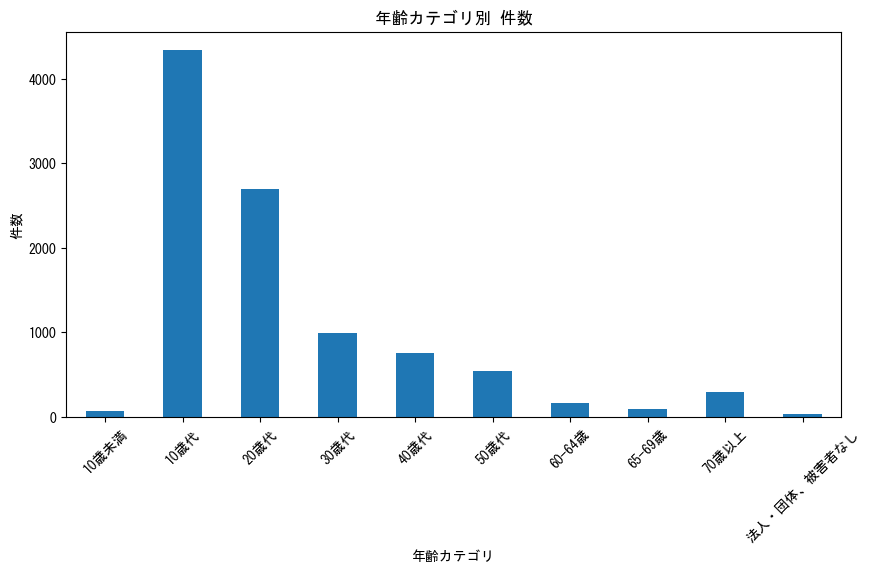

In [5]:
plt.figure(figsize=(10,5))
df['年齢カテゴリ'].value_counts().sort_index().plot(kind='bar')
plt.xlabel("年齢カテゴリ")
plt.ylabel("件数")
plt.title("年齢カテゴリ別 件数")
plt.xticks(rotation=45)
plt.show()


このグラフから被害者の年齢は10代と20代が多いことがわかります。
これは自転車を多く利用する年代であるということが関係していそうです。

次は年齢と施錠状態についてグラフにまとめ、考察します。

In [6]:
cross = pd.crosstab(df['被害者の年齢'], df['施錠関係'])
print(cross)


施錠関係         施錠した  施錠せず
被害者の年齢                 
10歳代         1046  3296
10歳未満           8    56
20歳代          932  1761
30歳代          402   584
40歳代          308   443
50歳代          222   315
60-64歳         66   100
65-69歳         40    48
70歳以上         135   151
法人・団体、被害者なし     3    27


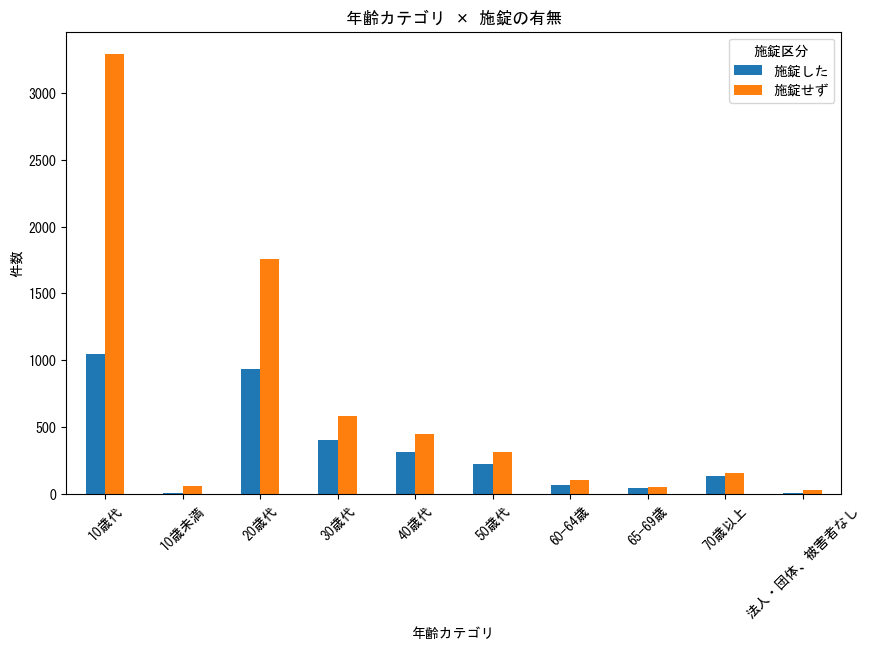

In [7]:
cross.plot(kind='bar', figsize=(10,6))
plt.xlabel("年齢カテゴリ")
plt.ylabel("件数")
plt.title("年齢カテゴリ × 施錠の有無")
plt.xticks(rotation=45)
plt.legend(title="施錠区分")
plt.show()


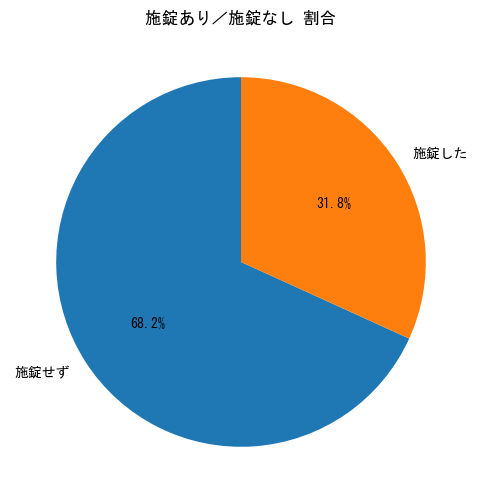

In [8]:
lock_counts = df["施錠関係"].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(lock_counts, labels=lock_counts.index, autopct="%1.1f%%", startangle=90)
plt.title("施錠あり／施錠なし 割合")
plt.show()

10代の被害者が最も鍵の閉め忘れが多いことがわかります。
主に通学に利用する層であることから、移動を急ぐことが多く、その結果締め忘れが出てしまうということが考えられます。

次に、各市区町村の自転車盗難発生数を各区役所、市役所にマッピングした地図を作って考察していきます。

In [9]:
geolocator = Nominatim(user_agent="my_app")

def get_lat_lon(address):
    try:
        location = geolocator.geocode("日本 " + str(address))
        time.sleep(1)
        if location:
            return pd.Series([location.latitude, location.longitude])
        else:
            return pd.Series([np.nan, np.nan])
    except:
        return pd.Series([np.nan, np.nan])


In [10]:
latlon_dict = {
    "千葉市中央区": (35.6073, 140.1064),
    "千葉市緑区": (35.5600, 140.2612),
    "習志野市": (35.6780, 140.0280),
    "船橋市": (35.6940, 139.9826),
    "市川市": (35.7210, 139.9312),
    "浦安市": (35.6530, 139.9014),
    "松戸市": (35.7870, 139.9032),
    "野田市": (35.9515, 139.8740),
    "柏市": (35.8680, 139.9750),
    "八街市": (35.6690, 140.3180),
    "佐倉市": (35.7230, 140.2280),
    "酒々井町": (35.7308, 140.2638),
    "成田市": (35.7767, 140.3186),
    "栄町": (35.8730, 140.2550),
    "富里市": (35.7260, 140.3320),
    "鎌ケ谷市": (35.7800, 140.0000),
    "印西市": (35.8290, 140.1350),
    "白井市": (35.7940, 140.0540),
    "多古町": (35.7360, 140.4680),
    "香取市": (35.8975, 140.4990),
    "東庄町": (35.8120, 140.6660),
    "神崎町": (35.8930, 140.3540),
    "銚子市": (35.7340, 140.8260),
    "旭市": (35.7153, 140.6465),
    "匝瑳市": (35.7050, 140.5660),
    "山武市": (35.6040, 140.4180),
    "横芝光町": (35.6800, 140.5035),
    "東金市": (35.5600, 140.3680),
    "大網白里市": (35.5220, 140.3220),
    "九十九里町": (35.5410, 140.4190),
    "一宮町": (35.3780, 140.3750),
    "茂原市": (35.4260, 140.3020),
    "白子町": (35.4880, 140.3920),
    "睦沢町": (35.3580, 140.3100),
    "長生村": (35.4120, 140.3580),
    "いすみ市": (35.2440, 140.3910),
    "御宿町": (35.1850, 140.3500),
    "勝浦市": (35.1520, 140.3180),
    "市原市": (35.5050, 140.1220),
    "木更津市": (35.3700, 139.9160),
    "袖ケ浦市": (35.4270, 139.9540),
    "君津市": (35.3300, 139.8830),
    "富津市": (35.3150, 139.8550),
    "南房総市": (35.0600, 139.9100),
    "鋸南町": (35.0920, 139.8360),
    "館山市": (34.9960, 139.8690),
    "鴨川市": (35.1130, 140.1000),
    "千葉市稲毛区": (35.6350, 140.0930),
    "千葉市美浜区": (35.6400, 140.0630),
    "千葉市花見川区": (35.6610, 140.0670),
    "八千代市": (35.7220, 140.0980),
    "我孫子市": (35.8710, 140.0120),
    "流山市": (35.8560, 139.9020),
    "千葉市若葉区": (35.6512, 140.1847),
    "四街道市": (35.6680, 140.1680),
}


In [11]:
df['lat'] = df['市区町村（発生地）'].map(lambda x: latlon_dict.get(x, (np.nan, np.nan))[0])
df['lon'] = df['市区町村（発生地）'].map(lambda x: latlon_dict.get(x, (np.nan, np.nan))[1])


In [12]:
df_map = df.dropna(subset=["lat", "lon"])

m = folium.Map(location=[35.6, 140.1], zoom_start=9)
HeatMap(df_map[['lat','lon']].values, radius=10).add_to(m)

m.save("map.html")




地図を見ると船橋市や市川市で多く自転車盗難が発生しているということがわかります。
この二つの市は隣り合わせで、人が集まる地域のためこのような結果になったと考えられます。

#まとめ（気を付けるべきことと対応策）
自転車盗難を受けた被害者の多くが10代、20代で、通勤通学に利用することが多い人々です。また、この年代の人々は施錠ができていなかった人も多いので特に注意するべき。
鍵の施錠をしていても盗難にあった人々が約30％近くいるため、軽く小さいかぎの使用ではなく、重く、大きな解錠しにくいかぎの使用や二重に施錠をするなどの対応策がおすすめ。
盗難被害の多い船橋市や市川市では施錠の呼びかけや監視カメラの増設など市全体として対策を行っていくべき。